# Neural Style Transfer

This notebook implements *neural style transfer* presented in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

<img src="https://miro.medium.com/max/1400/1*MAjeF5fiRosZP6PMtAQp_Q.jpeg" style="width: 500px;"/>

This example is based on a [TF tutorial](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/style_transfer.ipynb?authuser=2#scrollTo=Yh_AV6220ebD).


## Step 0: Setup

Let's start by installing Tensorflow 2.0 and removing old files.

In [1]:
# Install TF 2.0
!pip install tensorflow-gpu==2.0.0-beta1

# Remove old files
!rm content.*
!rm style.*
!rm pepe.*

     |████████████████████████████████| 348.9MB 43kB/s 
     |████████████████████████████████| 3.1MB 40.3MB/s 
     |████████████████████████████████| 501kB 53.8MB/s 
rm: cannot remove 'content.*': No such file or directory
rm: cannot remove 'style.*': No such file or directory
rm: cannot remove 'pepe.*': No such file or directory


Let's import all the libraries we need.

In [0]:
# Plotting libraries
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

# Python utils libraries
import time
import functools

# Third party libraries
import numpy as np
import tensorflow as tf
from google.colab import files

**NOTE:** Check that the Colaboratory runtume is set to Python 3 and enables GPU computing.

## Step 1: Upload Content and Style Images

Now, we can upload any images we want for the content and sytle. Try your own!

**NOTE:** Remember to change the file names for the ones you uploaded.

In [5]:
# Upload files
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving pepe.jpeg to pepe.jpeg
Saving style.jpg to style.jpg
User uploaded file "pepe.jpeg" with length 136913 bytes
User uploaded file "style.jpg" with length 613563 bytes


In [0]:
# Reference to the file names
content_path = "pepe.jpeg"
style_path = "style.jpg"

Let's check the images we just uploaded.

In [0]:
# Function to load the image and resize it.
def load_img(path_to_img):
    max_dim = 512 # Resize shape 
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# Function to plot the image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)

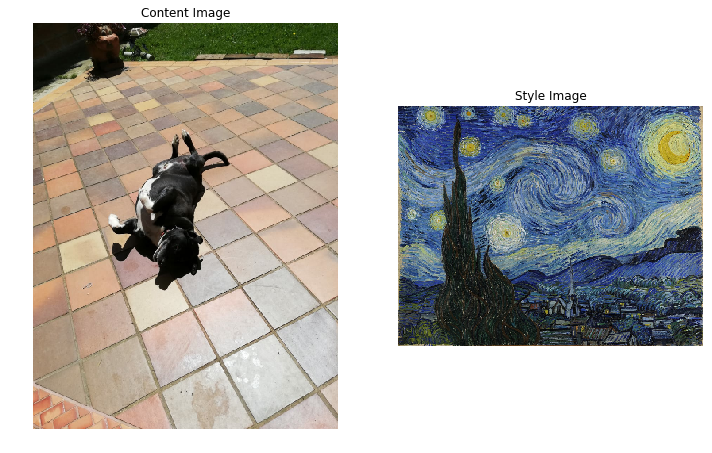

In [9]:
# Load both images
content_image = load_img(content_path)
style_image = load_img(style_path)

# Plot side-by-side.
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Step 2: Load Pre-trained CNN

For this implementation, following the original paper, we'll use VGG19 trained with the ImageNet dataset. Keras has a functionality to load this network weights.

Let's remebert how the VGG network looks like and how's implemented in Keras.

![alt text](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)

In [10]:
# Load VGG without the FC part and weights pre-trained in ImageNet.
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Print layers.
print("VGG Layers:")
for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 5s 0us/step
VGG Layers:
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


We can now select our layers of interest. 

In the original paper Intermediate layer for content is `conv4_2` and for style are `conv1_1`, `conv2_1`, `conv3_1`, `conv4_1`,  `conv5_1`, but you can choose any layer you want just remember that higher layers encode higher-level features of the images.

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block4_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

# Number of layers by content and style
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
# Function that return specified layers of VGG 
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Let's check the layer extractor by passing an image and check the output shapes.

In [13]:
# Extrct the style layers
style_extractor = vgg_layers(style_layers)

# Feed-forward the style image
style_outputs = style_extractor(style_image)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)

block1_conv1
  shape:  (1, 405, 512, 64)
block2_conv1
  shape:  (1, 202, 256, 128)
block3_conv1
  shape:  (1, 101, 128, 256)
block4_conv1
  shape:  (1, 50, 64, 512)
block5_conv1
  shape:  (1, 25, 32, 512)


## Step 3: Define Neural Style Transfer Model

For the content-style model, we need to define the Gram matrix operations and compute it for the style layers. 

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [0]:
# Function to compute the gram matrix as a Einstein summation
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # b=batch, i=height, j=width, b/c=channels.
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

Now we can define our model class with the style and context outputs.

In [0]:
# Model
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers) # Get VGG layers
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # Pre-process inputs for VGG Layers
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], # Slice style outputs
                                          outputs[self.num_style_layers:]) # Slice content outputs

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs] # Compute Gram Matrix for style
        
        # Create dictionary with outputs
        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

Let's test the Model class by passing the content image.

In [16]:
# Instatiate model with our layers
extractor = StyleContentModel(style_layers, content_layers)

# Pass content image through model
results = extractor(tf.constant(content_image))

# Print shapes
print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)


print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)

Styles:
   block1_conv1
    shape:  (1, 64, 64)
   block2_conv1
    shape:  (1, 128, 128)
   block3_conv1
    shape:  (1, 256, 256)
   block4_conv1
    shape:  (1, 512, 512)
   block5_conv1
    shape:  (1, 512, 512)
Contents:
   block4_conv2
    shape:  (1, 64, 48, 512)


## Step 4: Create the Loss Function

Once we have already our feed forward model for content and style extraction, we can define our targets, the optimizer to use, and the loss function.

In [0]:
# Extract our targets for style and content
style_targets = extractor(style_image)['style'] # Passed style image
content_targets = extractor(content_image)['content'] # Passed content

Instead of using a random noise image to start training, it is always better to use the same content image since will take slower to converge.

In [0]:
# Define content image as generated image to change pixels.
image = tf.Variable(content_image)

In [0]:
# Auxiliar function to clip values between 0 and 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
# Define our optimizer. Paper recommends LBFGS, but Adam works okay, too
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Original paper suggested an $\alpha / \beta $ ratio of $1 * 10^{-3} $ but you can try your own to apply more or less style / content.

In [0]:
# Define loss weights
style_weight=1e-1
content_weight=1e2

In [0]:
# Define the loss function
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    # Style loss
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # Content loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    # Total loss
    loss = style_loss + content_loss
    return loss

Now let's define our training step and execute three stepts to see it working.

In [0]:
# Train step
@tf.function() # TF decorator to compile function as a graph.
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

W0726 00:57:56.133515 140239535982464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(-0.5, 383.5, 511.5, -0.5)

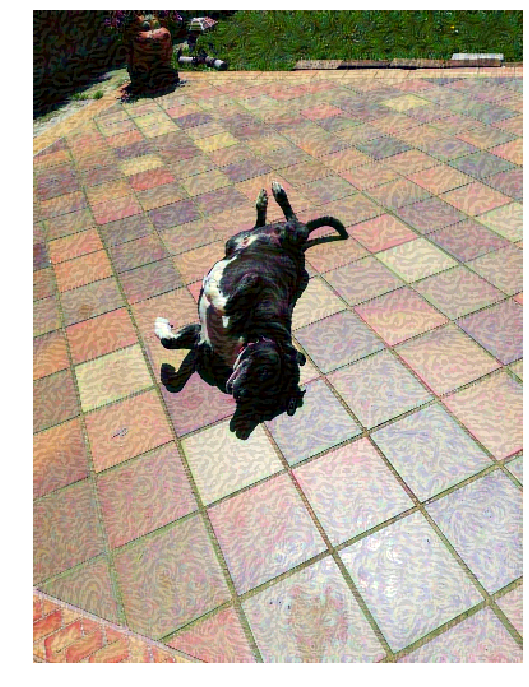

In [25]:
# Execute three training steps
train_step(image)
train_step(image)
train_step(image)

# Show transformed image with three training steps
plt.imshow(image.read_value()[0])
plt.axis("off")

Now that we checked that training step runs, let's run a full training.

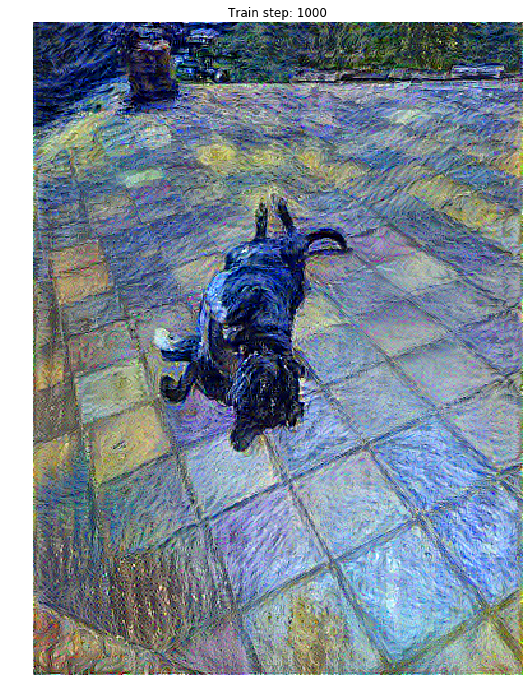

Total time: 81.2


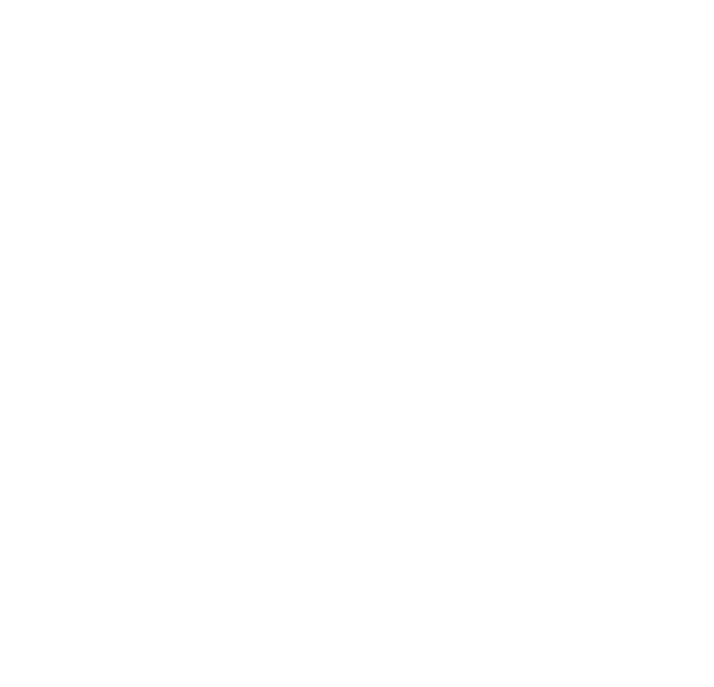

In [26]:
# Start time
start = time.time()

# Define number of epochs and steps per epoch
epochs = 10
steps_per_epoch = 100

# Start training loop
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    
    # Plot image for every epoch
    display.clear_output(wait=True)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()
    plt.axis("off")

# End time and total time training
end = time.time()
print("Total time: {:.1f}".format(end-start))

## Step 5: Add Total Variational Loss (Optional)

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

$$ \sum _{i,j}(y_{i+1,j}-y_{i,j})^{2}+(y_{i,j+1}-y_{i,j})^{2} $$


In [0]:
# Define vertical and horizontal variation
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

In [0]:
# Define total var loss
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [0]:
# Weight for total var loss
total_variation_weight=1e8

In [0]:
# Create a training step with total var
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*total_variation_loss(image) # add total var loss

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [0]:
# Use content image as starting point
image = tf.Variable(content_image)

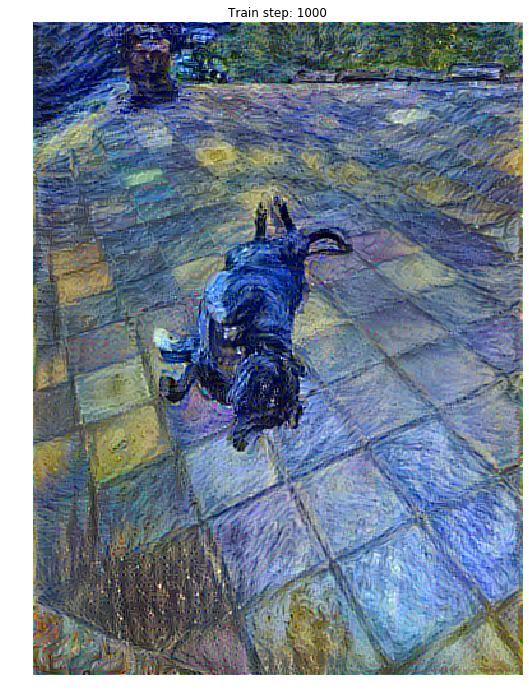

Total time: 85.1


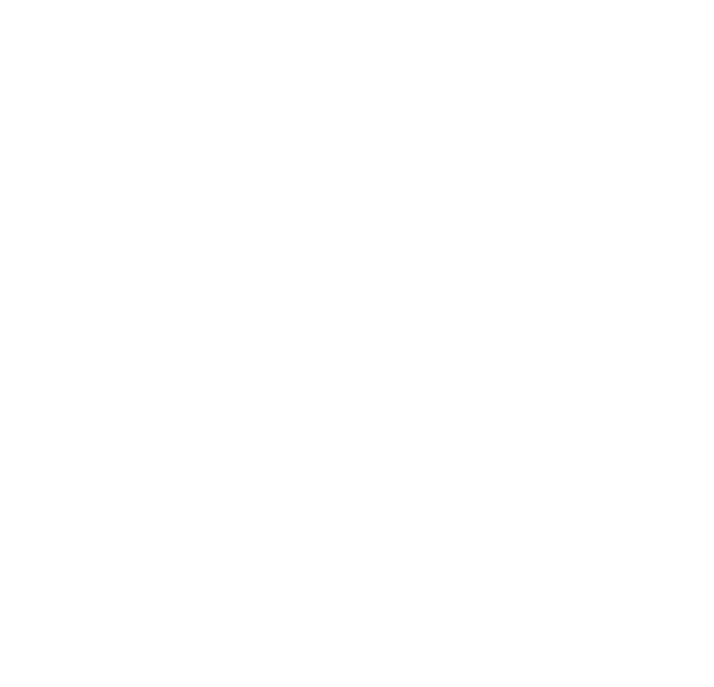

In [32]:
# Same training loop as above
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()
    plt.axis("off")

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [0]:
# Download generated image to your PC. Only works on Chrome.
file_name = 'generated.png'
mpl.image.imsave(file_name, image[0])
files.download(file_name)